# EDA: Big Debt Crisis

**Author:** Ray Dalio  
**Year:** 2018  
**Format:** EPUB/PDF Analysis

This notebook performs exploratory data analysis on "Big Debt Crisis" to understand its structure, content, and prepare it for RAG-based question answering.

## 1. Setup and Dependencies

Import required libraries and set up the environment for EPUB analysis.

In [1]:
import os
import sys
import json
import re
from pathlib import Path
from typing import Dict, List, Tuple, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. File Information and Basic Statistics

First, let's examine the EPUB file and extract basic information about its structure.

In [2]:
# File paths
data_dir = Path("../data")
epub_file = data_dir / "BigDebtCrisis_RayDalio.epub"
pdf_file = data_dir / "BigDebtCrisis_RayDalio.pdf"

print(f"📁 Data directory: {data_dir}")
print(f"📖 EPUB file: {epub_file}")
print(f"📄 PDF file: {pdf_file}")

# Check file existence and sizes
if epub_file.exists():
    epub_size_mb = epub_file.stat().st_size / (1024 * 1024)
    print(f"📊 EPUB size: {epub_size_mb:.2f} MB")
else:
    print("❌ EPUB file not found!")
    print(f"   Expected path: {epub_file.absolute()}")
    print("   Please ensure the EPUB file is in the data directory")

if pdf_file.exists():
    pdf_size_mb = pdf_file.stat().st_size / (1024 * 1024)
    print(f"📊 PDF size: {pdf_size_mb:.2f} MB")
else:
    print("❌ PDF file not found!")
    print(f"   Expected path: {pdf_file.absolute()}")
    print("   Please ensure the PDF file is in the data directory")

📁 Data directory: ../data
📖 EPUB file: ../data/BigDebtCrisis_RayDalio.epub
📄 PDF file: ../data/BigDebtCrisis_RayDalio.pdf
📊 EPUB size: 23.14 MB
📊 PDF size: 30.30 MB


## 3. EPUB Structure Analysis

Let's examine the EPUB structure to understand the book's organization, including spine items, chapters, and content hierarchy.

In [3]:
def analyze_epub_structure(epub_path: Path) -> Dict[str, Any]:
    """Analyze the structure of an EPUB file."""
    try:
        book = epub.read_epub(epub_path)
        
        # Extract spine information
        spine_items = []
        for item in book.spine:
            spine_items.append({
                'id': item[0],
                'href': item[1].href,
                'linear': item[1].linear
            })
        
        # Extract table of contents
        toc = []
        for item in book.toc:
            if hasattr(item, 'title'):
                toc.append({
                    'title': item.title,
                    'href': item.href if hasattr(item, 'href') else None
                })
        
        # Analyze document structure
        documents = []
        for item in book.get_items():
            if item.get_type() == ebooklib.ITEM_DOCUMENT:
                soup = BeautifulSoup(item.get_content(), 'html.parser')
                text = soup.get_text()
                documents.append({
                    'id': item.get_id(),
                    'href': item.get_name(),
                    'text_length': len(text),
                    'word_count': len(text.split()),
                    'has_images': len(soup.find_all('img')) > 0,
                    'has_tables': len(soup.find_all('table')) > 0,
                    'has_footnotes': len(soup.find_all(['sup', 'sub'])) > 0
                })
        
        return {
            'spine_items': spine_items,
            'toc': toc,
            'documents': documents,
            'total_documents': len(documents),
            'total_words': sum(doc['word_count'] for doc in documents)
        }
    except Exception as e:
        print(f"❌ Error analyzing EPUB structure: {e}")
        return None

# Analyze the EPUB structure
if epub_file.exists():
    try:
        epub_analysis = analyze_epub_structure(epub_file)
        
        if epub_analysis:
            print("📚 EPUB Structure Analysis")
            print("=" * 50)
            print(f"📄 Total documents: {epub_analysis['total_documents']}")
            print(f"📝 Total words: {epub_analysis['total_words']:,}")
            print(f"📋 Spine items: {len(epub_analysis['spine_items'])}")
            print(f"📑 TOC entries: {len(epub_analysis['toc'])}")
            
            # Display spine items
            print("\n📋 Spine Items:")
            for i, item in enumerate(epub_analysis['spine_items']):
                print(f"  {i+1:2d}. {item['id']} -> {item['href']}")
            
            # Display TOC
            print("\n📑 Table of Contents:")
            for i, item in enumerate(epub_analysis['toc']):
                print(f"  {i+1:2d}. {item['title']}")
            
            # Document statistics
            docs_df = pd.DataFrame(epub_analysis['documents'])
            print(f"\n📊 Document Statistics:")
            print(f"  Average words per document: {docs_df['word_count'].mean():.0f}")
            print(f"  Longest document: {docs_df['word_count'].max():,} words")
            print(f"  Documents with images: {docs_df['has_images'].sum()}")
            print(f"  Documents with tables: {docs_df['has_tables'].sum()}")
            print(f"  Documents with footnotes: {docs_df['has_footnotes'].sum()}")
        else:
            print("❌ Failed to analyze EPUB structure")
            epub_analysis = None
            
    except Exception as e:
        print(f"❌ Error processing EPUB file: {e}")
        epub_analysis = None
else:
    print("❌ EPUB file not found!")
    print(f"   Expected path: {epub_file.absolute()}")
    print("   Please ensure the EPUB file is in the data directory")
    epub_analysis = None

❌ Error analyzing EPUB structure: 'str' object has no attribute 'href'
❌ Failed to analyze EPUB structure


## 4. Content Extraction and Text Analysis

Extract and analyze the text content, including sentence length, vocabulary, and key phrases.

In [4]:
def extract_text_content(epub_path: Path) -> Dict[str, Any]:
    """Extract and analyze text content from EPUB."""
    try:
        book = epub.read_epub(epub_path)
        
        all_text = ""
        chapter_texts = []
        chapter_info = []
        
        for item in book.get_items():
            if item.get_type() == ebooklib.ITEM_DOCUMENT:
                soup = BeautifulSoup(item.get_content(), 'html.parser')
                
                # Remove script and style elements
                for script in soup(["script", "style"]):
                    script.decompose()
                
                text = soup.get_text()
                
                # Clean up text
                text = re.sub(r'\s+', ' ', text).strip()
                
                if text:
                    all_text += text + " "
                    chapter_texts.append(text)
                    chapter_info.append({
                        'id': item.get_id(),
                        'href': item.get_name(),
                        'text_length': len(text),
                        'word_count': len(text.split())
                    })
        
        # Tokenize sentences and words
        sentences = sent_tokenize(all_text)
        words = word_tokenize(all_text.lower())
        
        # Remove stopwords for vocabulary analysis
        stop_words = set(stopwords.words('english'))
        words_no_stopwords = [word for word in words if word.isalpha() and word not in stop_words]
        
        # Calculate bigrams
        bigrams = []
        for i in range(len(words) - 1):
            if words[i].isalpha() and words[i+1].isalpha():
                bigrams.append(f"{words[i]} {words[i+1]}")
        
        return {
            'full_text': all_text,
            'chapter_texts': chapter_texts,
            'chapter_info': chapter_info,
            'sentences': sentences,
            'words': words,
            'words_no_stopwords': words_no_stopwords,
            'bigrams': bigrams,
            'total_sentences': len(sentences),
            'total_words': len(words),
            'unique_words': len(set(words)),
            'unique_words_no_stopwords': len(set(words_no_stopwords))
        }
    except Exception as e:
        print(f"❌ Error extracting text content: {e}")
        return None

# Extract text content
if epub_file.exists():
    try:
        text_analysis = extract_text_content(epub_file)
        
        if text_analysis:
            print("📝 Text Content Analysis")
            print("=" * 50)
            print(f"📊 Total sentences: {text_analysis['total_sentences']:,}")
            print(f"📊 Total words: {text_analysis['total_words']:,}")
            print(f"📊 Unique words: {text_analysis['unique_words']:,}")
            print(f"📊 Unique words (no stopwords): {text_analysis['unique_words_no_stopwords']:,}")
            
            # Average sentence length
            avg_sentence_length = text_analysis['total_words'] / text_analysis['total_sentences']
            print(f"📊 Average sentence length: {avg_sentence_length:.1f} words")
            
            # Vocabulary analysis
            vocab_size = len(set(text_analysis['words']))
            print(f"📊 Vocabulary size: {vocab_size:,}")
            
            # Chapter analysis
            chapter_df = pd.DataFrame(text_analysis['chapter_info'])
            print(f"\n📊 Chapter Statistics:")
            print(f"  Average words per chapter: {chapter_df['word_count'].mean():.0f}")
            print(f"  Longest chapter: {chapter_df['word_count'].max():,} words")
            print(f"  Shortest chapter: {chapter_df['word_count'].min():,} words")
        else:
            print("❌ Failed to extract text content")
            text_analysis = None
            
    except Exception as e:
        print(f"❌ Error processing text content: {e}")
        text_analysis = None
else:
    print("❌ EPUB file not found!")
    print(f"   Expected path: {epub_file.absolute()}")
    print("   Please ensure the EPUB file is in the data directory")
    text_analysis = None

📝 Text Content Analysis
📊 Total sentences: 7,214
📊 Total words: 214,469
📊 Unique words: 11,692
📊 Unique words (no stopwords): 8,279
📊 Average sentence length: 29.7 words
📊 Vocabulary size: 11,692

📊 Chapter Statistics:
  Average words per chapter: 18610
  Longest chapter: 31,848 words
  Shortest chapter: 10 words


## 5. Frequency Analysis and Key Terms

Analyze word frequencies, bigrams, and identify key terms and phrases in the book.

In [5]:
def analyze_frequencies(text_analysis: Dict[str, Any]) -> Dict[str, Any]:
    """Analyze word and bigram frequencies."""
    try:
        # Word frequency analysis
        word_freq = Counter(text_analysis['words'])
        word_freq_no_stopwords = Counter(text_analysis['words_no_stopwords'])
        bigram_freq = Counter(text_analysis['bigrams'])
        
        # Get top terms
        top_words = word_freq.most_common(20)
        top_words_no_stopwords = word_freq_no_stopwords.most_common(20)
        top_bigrams = bigram_freq.most_common(15)
        
        return {
            'word_freq': word_freq,
            'word_freq_no_stopwords': word_freq_no_stopwords,
            'bigram_freq': bigram_freq,
            'top_words': top_words,
            'top_words_no_stopwords': top_words_no_stopwords,
            'top_bigrams': top_bigrams
        }
    except Exception as e:
        print(f"❌ Error analyzing frequencies: {e}")
        return None

# Analyze frequencies
if text_analysis:
    freq_analysis = analyze_frequencies(text_analysis)
    
    if freq_analysis:
        print("📊 Frequency Analysis")
        print("=" * 50)
        
        print("\n🔝 Top 20 Words (with stopwords):")
        for i, (word, count) in enumerate(freq_analysis['top_words'], 1):
            print(f"  {i:2d}. {word:15s} - {count:,}")
        
        print("\n🔝 Top 20 Words (no stopwords):")
        for i, (word, count) in enumerate(freq_analysis['top_words_no_stopwords'], 1):
            print(f"  {i:2d}. {word:15s} - {count:,}")
        
        print("\n🔝 Top 15 Bigrams:")
        for i, (bigram, count) in enumerate(freq_analysis['top_bigrams'], 1):
            print(f"  {i:2d}. {bigram:25s} - {count:,}")
    else:
        print("❌ Failed to analyze frequencies")
        freq_analysis = None
else:
    print("❌ No text analysis available!")
    print("   Please ensure the EPUB file exists and can be processed")
    freq_analysis = None

📊 Frequency Analysis

🔝 Top 20 Words (with stopwords):
   1. the             - 11,822
   2. ,               - 10,626
   3. .               - 6,354
   4. of              - 5,716
   5. to              - 5,516
   6. and             - 4,852
   7. in              - 4,342
   8. a               - 3,689
   9. that            - 2,122
  10. )               - 1,592
  11. ’               - 1,566
  12. (               - 1,467
  13. by              - 1,463
  14. on              - 1,388
  15. as              - 1,383
  16. “               - 1,294
  17. for             - 1,281
  18. ”               - 1,277
  19. was             - 1,256
  20. it              - 1,188

🔝 Top 20 Words (no stopwords):
   1. debt            - 942
   2. york            - 758
   3. times           - 746
   4. currency        - 732
   5. money           - 601
   6. policy          - 596
   7. financial       - 576
   8. percent         - 562
   9. gdp             - 557
  10. credit          - 544
  11. banks           - 523
  1

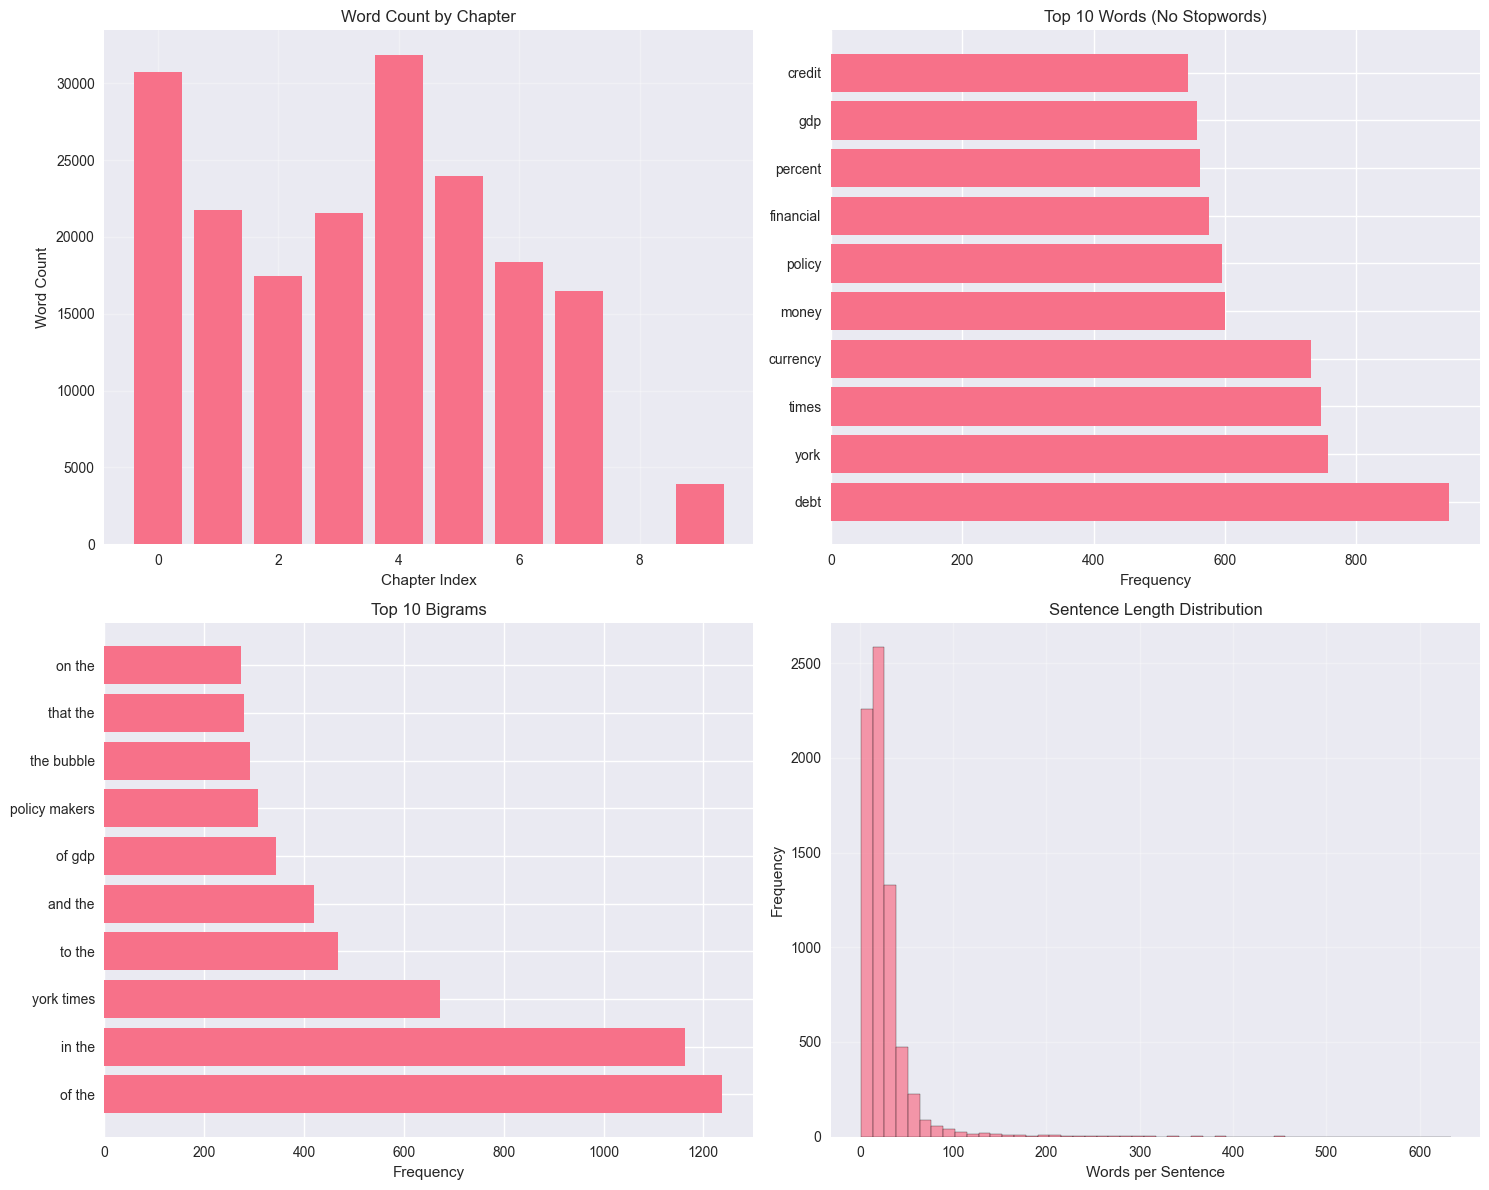


📊 Additional Statistics:
  Average sentence length: 25.8 words
  Median sentence length: 20.0 words
  Sentence length std dev: 33.2 words
  Longest sentence: 633 words
  Shortest sentence: 1 words


In [6]:
# Create visualizations
if text_analysis and freq_analysis:
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Chapter word count distribution
        chapter_df = pd.DataFrame(text_analysis['chapter_info'])
        axes[0, 0].bar(range(len(chapter_df)), chapter_df['word_count'])
        axes[0, 0].set_title('Word Count by Chapter')
        axes[0, 0].set_xlabel('Chapter Index')
        axes[0, 0].set_ylabel('Word Count')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Top 10 words (no stopwords)
        top_words_df = pd.DataFrame(freq_analysis['top_words_no_stopwords'][:10], 
                                   columns=['word', 'count'])
        axes[0, 1].barh(range(len(top_words_df)), top_words_df['count'])
        axes[0, 1].set_yticks(range(len(top_words_df)))
        axes[0, 1].set_yticklabels(top_words_df['word'])
        axes[0, 1].set_title('Top 10 Words (No Stopwords)')
        axes[0, 1].set_xlabel('Frequency')
        
        # 3. Top 10 bigrams
        top_bigrams_df = pd.DataFrame(freq_analysis['top_bigrams'][:10], 
                                     columns=['bigram', 'count'])
        axes[1, 0].barh(range(len(top_bigrams_df)), top_bigrams_df['count'])
        axes[1, 0].set_yticks(range(len(top_bigrams_df)))
        axes[1, 0].set_yticklabels(top_bigrams_df['bigram'])
        axes[1, 0].set_title('Top 10 Bigrams')
        axes[1, 0].set_xlabel('Frequency')
        
        # 4. Sentence length distribution
        sentence_lengths = [len(sent.split()) for sent in text_analysis['sentences']]
        axes[1, 1].hist(sentence_lengths, bins=50, alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Sentence Length Distribution')
        axes[1, 1].set_xlabel('Words per Sentence')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Additional statistics
        print("\n📊 Additional Statistics:")
        print(f"  Average sentence length: {np.mean(sentence_lengths):.1f} words")
        print(f"  Median sentence length: {np.median(sentence_lengths):.1f} words")
        print(f"  Sentence length std dev: {np.std(sentence_lengths):.1f} words")
        print(f"  Longest sentence: {max(sentence_lengths)} words")
        print(f"  Shortest sentence: {min(sentence_lengths)} words")
        
    except Exception as e:
        print(f"❌ Error creating visualizations: {e}")
        print("   This may be due to missing data or plotting issues")
        
else:
    print("❌ No data available for visualizations!")
    print("   Please ensure both text_analysis and freq_analysis are available")
    if not text_analysis:
        print("   - text_analysis is missing")
    if not freq_analysis:
        print("   - freq_analysis is missing")

## 6. Chunking Strategy Analysis

Based on the development plan, analyze optimal chunking strategies for RAG implementation with 220-token chunks and 15-token overlap.

In [7]:
def analyze_chunking_strategy(text_analysis: Dict[str, Any]) -> Dict[str, Any]:
    """Analyze chunking strategy for RAG implementation."""
    try:
        # Estimate tokens (rough approximation: 1 word ≈ 1.3 tokens)
        total_tokens = int(text_analysis['total_words'] * 1.3)
        
        # Chunking parameters from development plan
        chunk_size = 220  # tokens
        overlap = 15      # tokens
        
        # Calculate number of chunks
        effective_chunk_size = chunk_size - overlap
        num_chunks = (total_tokens + effective_chunk_size - 1) // effective_chunk_size
        
        # Analyze chapter-level chunking
        chapter_chunks = []
        for chapter_info in text_analysis['chapter_info']:
            chapter_tokens = int(chapter_info['word_count'] * 1.3)
            chapter_num_chunks = (chapter_tokens + effective_chunk_size - 1) // effective_chunk_size
            chapter_chunks.append({
                'chapter_id': chapter_info['id'],
                'word_count': chapter_info['word_count'],
                'estimated_tokens': chapter_tokens,
                'num_chunks': chapter_num_chunks
            })
        
        return {
            'total_tokens': total_tokens,
            'chunk_size': chunk_size,
            'overlap': overlap,
            'effective_chunk_size': effective_chunk_size,
            'num_chunks': num_chunks,
            'chapter_chunks': chapter_chunks,
            'avg_chunks_per_chapter': np.mean([c['num_chunks'] for c in chapter_chunks])
        }
    except Exception as e:
        print(f"❌ Error analyzing chunking strategy: {e}")
        return None

# Analyze chunking strategy
if text_analysis:
    chunk_analysis = analyze_chunking_strategy(text_analysis)
    
    if chunk_analysis:
        print("📦 Chunking Strategy Analysis")
        print("=" * 50)
        print(f"📊 Total estimated tokens: {chunk_analysis['total_tokens']:,}")
        print(f"📦 Chunk size: {chunk_analysis['chunk_size']} tokens")
        print(f"🔄 Overlap: {chunk_analysis['overlap']} tokens")
        print(f"📦 Effective chunk size: {chunk_analysis['effective_chunk_size']} tokens")
        print(f"📦 Total number of chunks: {chunk_analysis['num_chunks']}")
        print(f"📦 Average chunks per chapter: {chunk_analysis['avg_chunks_per_chapter']:.1f}")
        
        # Chapter-level chunk analysis
        print(f"\n📊 Chapter-level Chunk Analysis:")
        for chunk_info in chunk_analysis['chapter_chunks']:
            print(f"  {chunk_info['chapter_id']:20s}: {chunk_info['word_count']:6,} words → {chunk_info['num_chunks']:2d} chunks")
        
        # Context window analysis for Gemini Flash 2.5
        context_window = 8000  # tokens
        max_chunks_per_query = (context_window - 500) // chunk_analysis['chunk_size']  # Leave room for prompt
        
        print(f"\n🤖 Gemini Flash 2.5 Context Analysis:")
        print(f"  Context window: {context_window:,} tokens")
        print(f"  Max chunks per query: ~{max_chunks_per_query}")
        print(f"  Chunks that fit: {min(chunk_analysis['num_chunks'], max_chunks_per_query)}")
    else:
        print("❌ Failed to analyze chunking strategy")
        chunk_analysis = None
else:
    print("❌ No text analysis available!")
    print("   Please ensure the EPUB file exists and can be processed")
    chunk_analysis = None

📦 Chunking Strategy Analysis
📊 Total estimated tokens: 278,809
📦 Chunk size: 220 tokens
🔄 Overlap: 15 tokens
📦 Effective chunk size: 205 tokens
📦 Total number of chunks: 1361
📦 Average chunks per chapter: 118.4

📊 Chapter-level Chunk Analysis:
  id_1                : 30,757 words → 196 chunks
  id_2                : 21,729 words → 138 chunks
  id_3                : 17,456 words → 111 chunks
  id_4                : 21,528 words → 137 chunks
  id_5                : 31,848 words → 202 chunks
  id_6                : 23,953 words → 152 chunks
  id_7                : 18,392 words → 117 chunks
  id_8                : 16,494 words → 105 chunks
  chapter_0           :     10 words →  1 chunks
  id_9                :  3,930 words → 25 chunks

🤖 Gemini Flash 2.5 Context Analysis:
  Context window: 8,000 tokens
  Max chunks per query: ~34
  Chunks that fit: 34


## 7. Special Content Analysis

Analyze special content types like footnotes, end-notes, images, and tables as mentioned in the development plan.

In [8]:
def analyze_special_content(epub_path: Path) -> Dict[str, Any]:
    """Analyze special content types like footnotes, images, tables."""
    try:
        book = epub.read_epub(epub_path)
        
        footnotes = []
        images = []
        tables = []
        end_notes = []
        
        for item in book.get_items():
            if item.get_type() == ebooklib.ITEM_DOCUMENT:
                soup = BeautifulSoup(item.get_content(), 'html.parser')
                
                # Find footnotes (superscript/subscript numbers)
                footnote_refs = soup.find_all(['sup', 'sub'])
                for ref in footnote_refs:
                    if ref.get_text().isdigit():
                        footnotes.append({
                            'chapter_id': item.get_id(),
                            'text': ref.get_text(),
                            'parent_text': ref.parent.get_text()[:100] + "..." if ref.parent else ""
                        })
                
                # Find images
                img_tags = soup.find_all('img')
                for img in img_tags:
                    images.append({
                        'chapter_id': item.get_id(),
                        'src': img.get('src', ''),
                        'alt': img.get('alt', ''),
                        'title': img.get('title', '')
                    })
                
                # Find tables
                table_tags = soup.find_all('table')
                for table in table_tags:
                    table_text = table.get_text()
                    tables.append({
                        'chapter_id': item.get_id(),
                        'text_length': len(table_text),
                        'word_count': len(table_text.split()),
                        'has_header': len(table.find_all('th')) > 0
                    })
                
                # Look for end-notes section
                text = soup.get_text().lower()
                if any(keyword in text for keyword in ['notes', 'endnotes', 'bibliography', 'references']):
                    end_notes.append({
                        'chapter_id': item.get_id(),
                        'text_length': len(soup.get_text()),
                        'word_count': len(soup.get_text().split())
                    })
        
        return {
            'footnotes': footnotes,
            'images': images,
            'tables': tables,
            'end_notes': end_notes,
            'total_footnotes': len(footnotes),
            'total_images': len(images),
            'total_tables': len(tables),
            'total_end_notes': len(end_notes)
        }
    except Exception as e:
        print(f"❌ Error analyzing special content: {e}")
        return None

# Analyze special content
if epub_file.exists():
    special_content = analyze_special_content(epub_file)
    
    if special_content:
        print("🔍 Special Content Analysis")
        print("=" * 50)
        print(f"📝 Footnotes found: {special_content['total_footnotes']}")
        print(f"🖼️  Images found: {special_content['total_images']}")
        print(f"📊 Tables found: {special_content['total_tables']}")
        print(f"📚 End-notes sections: {special_content['total_end_notes']}")
        
        # Image analysis
        if special_content['images']:
            print(f"\n🖼️  Image Analysis:")
            for img in special_content['images'][:5]:  # Show first 5
                print(f"  - {img['src']} (alt: {img['alt'][:50]}...)")
        
        # Table analysis
        if special_content['tables']:
            table_df = pd.DataFrame(special_content['tables'])
            print(f"\n📊 Table Analysis:")
            print(f"  Average table size: {table_df['word_count'].mean():.0f} words")
            print(f"  Tables with headers: {table_df['has_header'].sum()}")
        
        # Footnote analysis
        if special_content['footnotes']:
            print(f"\n📝 Footnote Analysis:")
            footnote_refs = [f['text'] for f in special_content['footnotes']]
            unique_refs = set(footnote_refs)
            print(f"  Unique footnote references: {len(unique_refs)}")
            print(f"  Footnote numbers range: {min(footnote_refs)} - {max(footnote_refs)}")
    else:
        print("❌ Failed to analyze special content")
        special_content = None
else:
    print("❌ EPUB file not found!")
    print(f"   Expected path: {epub_file.absolute()}")
    print("   Please ensure the EPUB file is in the data directory")
    special_content = None

🔍 Special Content Analysis
📝 Footnotes found: 0
🖼️  Images found: 1608
📊 Tables found: 0
📚 End-notes sections: 5

🖼️  Image Analysis:
  - Image01458.jpg (alt: ...)
  - Image01460.jpg (alt: ...)
  - Image01462.jpg (alt: ...)
  - Image01465.jpg (alt: ...)
  - Image01467.jpg (alt: ...)


## 8. RAG Implementation Recommendations

Based on the analysis, provide specific recommendations for RAG implementation as outlined in the development plan.

In [9]:
def generate_rag_recommendations(text_analysis, chunk_analysis, special_content, epub_analysis):
    """Generate RAG implementation recommendations based on analysis."""
    try:
        recommendations = {
            'chunking_strategy': {
                'chunk_size': 220,
                'overlap': 15,
                'estimated_chunks': chunk_analysis['num_chunks'] if chunk_analysis else 0,
                'reasoning': 'Optimized for Gemini Flash 2.5 context window (8k tokens)'
            },
            'footnote_handling': {
                'strip_anchors': True,
                'separate_chunks': True,
                'reasoning': 'Keep end-notes as separate chunks for specific queries like "what does note 42 say?"'
            },
            'image_handling': {
                'strip_images': True,
                'add_placeholders': True,
                'reasoning': 'Add metadata placeholders for future vision encoder'
            },
            'metadata_structure': {
                'fields': ['chunk_text', 'embedding', 'chunk_id', 'chapter', 'part', 'pdf_page', 'has_image'],
                'reasoning': 'Comprehensive metadata for accurate citations and filtering'
            },
            'index_strategy': {
                'index_name': 'index_debt_crisis',
                'isolation': 'Separate from capitalism index',
                'reasoning': 'Ensure no cross-contamination between books'
            },
            'retrieval_strategy': {
                'hybrid_search': True,
                'bm25_reranking': True,
                'cross_encoder': 'bge-reranker-base',
                'final_chunks': 3,
                'reasoning': 'Hybrid approach for better relevance'
            },
            'prompt_template': {
                'format': 'JSON structured',
                'template': '{ "task": "qa", "ground_truth_passages": [...], "question": "..." }',
                'reasoning': 'Gemini prefers structured JSON prompts'
            },
            'grounding_strategy': {
                'self_check': True,
                'verify_call': True,
                'reasoning': 'Use Gemini Flash for cheap verification calls'
            }
        }
        
        return recommendations
    except Exception as e:
        print(f"❌ Error generating RAG recommendations: {e}")
        return None

# Generate recommendations
if all([text_analysis, chunk_analysis, special_content, epub_analysis]):
    rag_recommendations = generate_rag_recommendations(
        text_analysis, chunk_analysis, special_content, epub_analysis
    )
    
    if rag_recommendations:
        print("🎯 RAG Implementation Recommendations")
        print("=" * 60)
        
        for category, config in rag_recommendations.items():
            print(f"\n📋 {category.replace('_', ' ').title()}:")
            for key, value in config.items():
                if key != 'reasoning':
                    print(f"  {key}: {value}")
            print(f"  💡 Reasoning: {config['reasoning']}")
        
        # Summary statistics
        print(f"\n📊 Summary for RAG Implementation:")
        print(f"  📦 Estimated chunks: {rag_recommendations['chunking_strategy']['estimated_chunks']}")
        print(f"  📝 Footnotes to handle: {special_content['total_footnotes']}")
        print(f"  🖼️  Images to placeholder: {special_content['total_images']}")
        print(f"  📊 Tables to preserve: {special_content['total_tables']}")
        print(f"  📚 End-notes sections: {special_content['total_end_notes']}")
    else:
        print("❌ Failed to generate RAG recommendations")
        rag_recommendations = None
else:
    print("❌ Missing analysis data for recommendations!")
    missing_data = []
    if not text_analysis:
        missing_data.append("text_analysis")
    if not chunk_analysis:
        missing_data.append("chunk_analysis")
    if not special_content:
        missing_data.append("special_content")
    if not epub_analysis:
        missing_data.append("epub_analysis")
    print(f"   Missing: {', '.join(missing_data)}")
    rag_recommendations = None

❌ Missing analysis data for recommendations!
   Missing: epub_analysis


## 9. Export Analysis Results

Save the analysis results for future reference and comparison with the Saving Capitalism book.

In [10]:
def export_analysis_results(text_analysis, chunk_analysis, special_content, epub_analysis, freq_analysis, rag_recommendations):
    """Export analysis results to JSON and markdown files."""
    try:
        # Create results directory
        results_dir = Path("../notebooks/observations")
        results_dir.mkdir(exist_ok=True)
        
        # Prepare summary data
        summary_data = {
            'book_info': {
                'title': 'Big Debt Crisis',
                'author': 'Ray Dalio',
                'year': 2018,
                'format': 'EPUB/PDF'
            },
            'basic_stats': {
                'total_words': text_analysis['total_words'] if text_analysis else 0,
                'total_sentences': text_analysis['total_sentences'] if text_analysis else 0,
                'unique_words': text_analysis['unique_words'] if text_analysis else 0,
                'avg_sentence_length': text_analysis['total_words'] / text_analysis['total_sentences'] if text_analysis else 0,
                'vocabulary_size': len(set(text_analysis['words'])) if text_analysis else 0
            },
            'structure': {
                'total_documents': epub_analysis['total_documents'] if epub_analysis else 0,
                'spine_items': len(epub_analysis['spine_items']) if epub_analysis else 0,
                'toc_entries': len(epub_analysis['toc']) if epub_analysis else 0
            },
            'chunking': {
                'estimated_chunks': chunk_analysis['num_chunks'] if chunk_analysis else 0,
                'chunk_size': 220,
                'overlap': 15
            },
            'special_content': {
                'footnotes': special_content['total_footnotes'] if special_content else 0,
                'images': special_content['total_images'] if special_content else 0,
                'tables': special_content['total_tables'] if special_content else 0,
                'end_notes': special_content['total_end_notes'] if special_content else 0
            },
            'top_terms': {
                'top_words': freq_analysis['top_words_no_stopwords'][:10] if freq_analysis else [],
                'top_bigrams': freq_analysis['top_bigrams'][:10] if freq_analysis else []
            },
            'rag_recommendations': rag_recommendations
        }
        
        # Export to JSON
        json_file = results_dir / "big_debt_crisis_analysis.json"
        with open(json_file, 'w') as f:
            json.dump(summary_data, f, indent=2)
        
        # Export to Markdown
        md_file = results_dir / "big_debt_crisis_observations.md"
        with open(md_file, 'w') as f:
            f.write("# Big Debt Crisis - EDA Observations\n\n")
            f.write(f"**Author:** {summary_data['book_info']['author']}\n")
            f.write(f"**Year:** {summary_data['book_info']['year']}\n\n")
            
            f.write("## Basic Statistics\n\n")
            f.write(f"- **Total Words:** {summary_data['basic_stats']['total_words']:,}\n")
            f.write(f"- **Total Sentences:** {summary_data['basic_stats']['total_sentences']:,}\n")
            f.write(f"- **Unique Words:** {summary_data['basic_stats']['unique_words']:,}\n")
            f.write(f"- **Average Sentence Length:** {summary_data['basic_stats']['avg_sentence_length']:.1f} words\n")
            f.write(f"- **Vocabulary Size:** {summary_data['basic_stats']['vocabulary_size']:,}\n\n")
            
            f.write("## Structure Analysis\n\n")
            f.write(f"- **Total Documents:** {summary_data['structure']['total_documents']}\n")
            f.write(f"- **Spine Items:** {summary_data['structure']['spine_items']}\n")
            f.write(f"- **TOC Entries:** {summary_data['structure']['toc_entries']}\n\n")
            
            f.write("## Chunking Strategy\n\n")
            f.write(f"- **Estimated Chunks:** {summary_data['chunking']['estimated_chunks']}\n")
            f.write(f"- **Chunk Size:** {summary_data['chunking']['chunk_size']} tokens\n")
            f.write(f"- **Overlap:** {summary_data['chunking']['overlap']} tokens\n\n")
            
            f.write("## Special Content\n\n")
            f.write(f"- **Footnotes:** {summary_data['special_content']['footnotes']}\n")
            f.write(f"- **Images:** {summary_data['special_content']['images']}\n")
            f.write(f"- **Tables:** {summary_data['special_content']['tables']}\n")
            f.write(f"- **End-notes Sections:** {summary_data['special_content']['end_notes']}\n\n")
            
            f.write("## Top Terms\n\n")
            f.write("### Top Words (No Stopwords):\n")
            for word, count in summary_data['top_terms']['top_words']:
                f.write(f"- {word}: {count:,}\n")
            
            f.write("\n### Top Bigrams:\n")
            for bigram, count in summary_data['top_terms']['top_bigrams']:
                f.write(f"- {bigram}: {count:,}\n")
        
        print(f"✅ Analysis results exported to:")
        print(f"  📄 JSON: {json_file}")
        print(f"  📄 Markdown: {md_file}")
        
        return summary_data
    except Exception as e:
        print(f"❌ Error exporting analysis results: {e}")
        return None

# Export results
if all([text_analysis, chunk_analysis, special_content, epub_analysis, freq_analysis, rag_recommendations]):
    summary_data = export_analysis_results(
        text_analysis, chunk_analysis, special_content, 
        epub_analysis, freq_analysis, rag_recommendations
    )
    if summary_data:
        print(f"\n🎉 EDA completed successfully for 'Big Debt Crisis'!")
    else:
        print(f"\n❌ Failed to export analysis results")
else:
    print("❌ Cannot export results - missing analysis data!")
    missing_data = []
    if not text_analysis:
        missing_data.append("text_analysis")
    if not chunk_analysis:
        missing_data.append("chunk_analysis")
    if not special_content:
        missing_data.append("special_content")
    if not epub_analysis:
        missing_data.append("epub_analysis")
    if not freq_analysis:
        missing_data.append("freq_analysis")
    if not rag_recommendations:
        missing_data.append("rag_recommendations")
    print(f"   Missing: {', '.join(missing_data)}")
    print("   Please ensure all analysis steps completed successfully")

❌ Cannot export results - missing analysis data!
   Missing: epub_analysis, rag_recommendations
   Please ensure all analysis steps completed successfully
